## Hypothesis 1
#### Null Hypothesis: 
The quantity of a product in an order when no discount is given will be <strong>equal</strong> to the quantity of a product in an order when a discount is given.



#### Alternative Hypothesis:
The quantity of a product in an order when no discount is given will be <strong>less</strong> than the quantity of a product in an order when a discount is given.

In [30]:
import sqlite3
import funcs
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import Normalizer, MinMaxScaler
from scipy.stats import norm



In [3]:
DB = 'Northwind_small.sqlite'

In [4]:
query = 'select OrderId, ProductId, Quantity, Discount from OrderDetail order by ProductId;'
h1 = funcs.sql_to_df(DB, query)
h1.head()

,OrderId,ProductId,Quantity,Discount
0,10285,1,45,0.20
1,10294,1,18,0.00
2,10317,1,20,0.00
3,10348,1,15,0.15
4,10354,1,12,0.00


In [5]:
h1.describe()

,OrderId,ProductId,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,23.812993,0.056167
std,241.378032,22.159019,19.022047,0.083450
min,10248.000000,1.000000,1.000000,0.000000
25%,10451.000000,22.000000,10.000000,0.000000
50%,10657.000000,41.000000,20.000000,0.000000
75%,10862.500000,60.000000,30.000000,0.100000
max,11077.000000,77.000000,130.000000,0.250000


<BarContainer object of 77 artists>

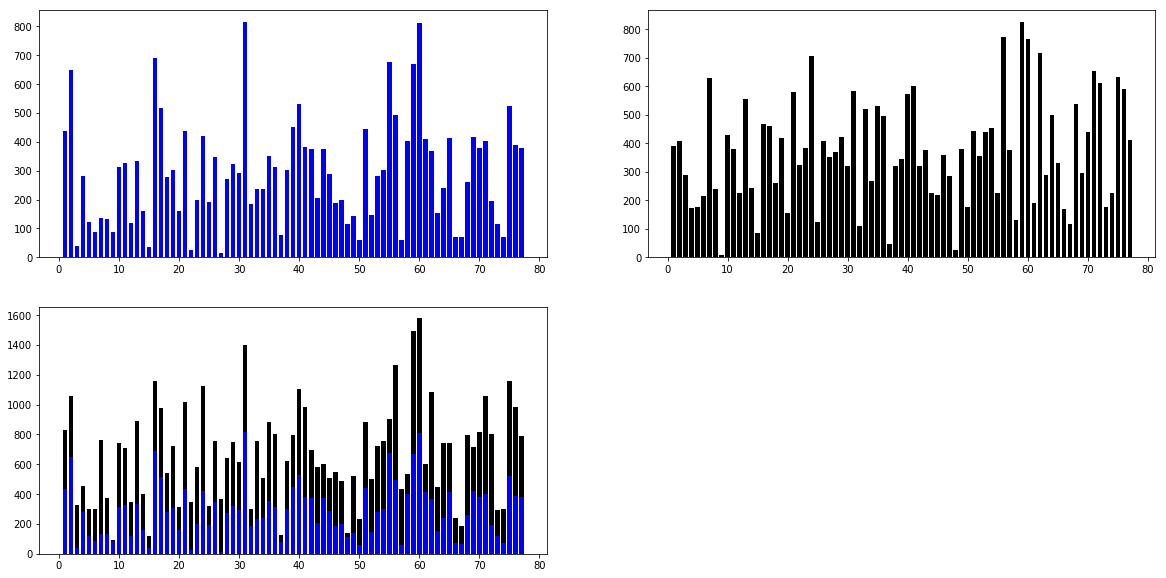

In [69]:
disc_counts = []
for i in range(1, len(h1['ProductId'].unique())+1):
    df = h1.loc[(h1['Discount'] > 0) & (h1['ProductId'] == i)]
    count = df['Quantity'].values.sum()
    disc_counts.append(count)

no_disc_counts = []
for i in range(1, len(h1['ProductId'].unique())+1):
    df = h1.loc[(h1['Discount'] == 0) & (h1['ProductId'] == i)]
    count = df['Quantity'].values.sum()
    no_disc_counts.append(count)
    
fig = plt.figure(figsize=(20,10))    
plt.subplot(221)
plt.bar(h1['ProductId'].unique(), disc_counts, color='blue')
plt.subplot(222)
plt.bar(h1['ProductId'].unique(), no_disc_counts, color='black')
plt.subplot(223)
plt.bar(h1['ProductId'].unique(), disc_counts, color='blue')
plt.bar(h1['ProductId'].unique(), no_disc_counts, color='black', bottom=disc_counts)

In [50]:
print(discount['Quantity'].values.sum())
print(no_discount['Quantity'].values.sum())

22718
28599


In [6]:
h1['bi_Discount'] = h1['Discount'].apply(lambda x: 1 if x > 0 else 0)

In [7]:
h1.head()

,OrderId,ProductId,Quantity,Discount,bi_Discount
0,10285,1,45,0.20,1
1,10294,1,18,0.00,0
2,10317,1,20,0.00,0
3,10348,1,15,0.15,1
4,10354,1,12,0.00,0


In [31]:
norm = Normalizer()
norm_h1 = norm.fit_transform(h1[['Quantity', 'Discount']])
norm_h1 = pd.DataFrame(norm_h1, columns=['quantity', 'discount'])
norm_h1.head()

scale = MinMaxScaler()
scaled_h1 = scale.fit_transform(h1[['Quantity', 'Discount']])
scaled_h1 = pd.DataFrame(scaled_h1, columns=['quantity', 'discount'])
scaled_h1.mean()

quantity    0.176845
discount    0.224668
dtype: float64

/Users/jackrisse/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


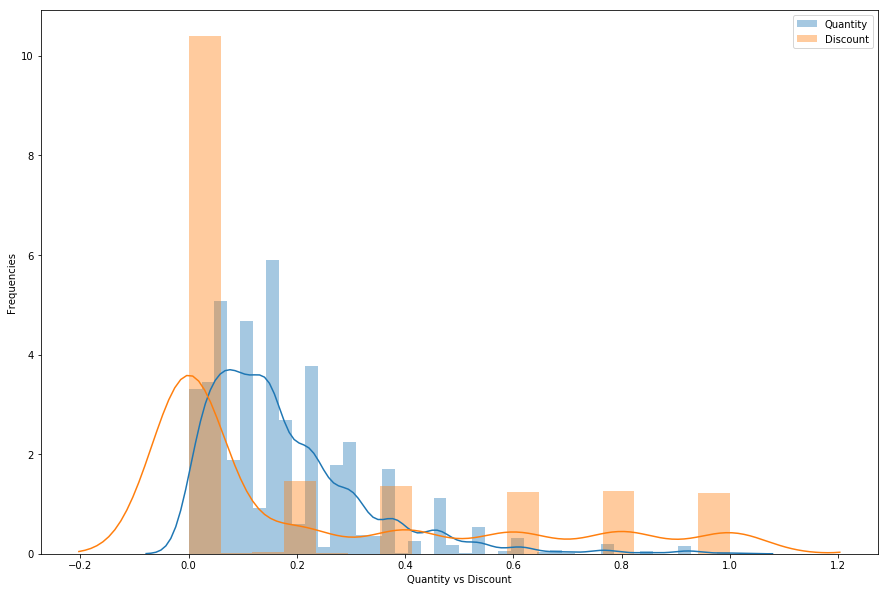

In [29]:
fig = plt.figure(figsize=(15,10))
sns.distplot(scaled_h1.quantity, label='Quantity')
sns.distplot(scaled_h1.discount, label='Discount')
plt.xlabel('Quantity vs Discount')
plt.ylabel('Frequencies')
plt.legend()

In [37]:
quant_mean, quant_std, disc_mean, disc_std = h1['Quantity'].mean(), h1['Quantity'].std(), h1['Discount'].mean(), h1['Discount'].std()
quant_n, disc_n = len(h1['Quantity']), len(h1['Discount'])
norm_h1['quantity'], norm_h1['discount'] = np.random.normal(quant_mean, quant_std, quant_n), np.random.normal(disc_mean, disc_std, disc_n)

In [40]:
h1['norm_quantity'], h1['norm_discount'] = norm_h1['quantity'], norm_h1['discount']
h1.head()

,OrderId,ProductId,Quantity,Discount,bi_Discount,norm_quantity,norm_discount
0,10285,1,45,0.20,1,60.407007,0.123742
1,10294,1,18,0.00,0,42.175931,0.067386
2,10317,1,20,0.00,0,-4.348389,0.033442
3,10348,1,15,0.15,1,10.369887,0.051135
4,10354,1,12,0.00,0,18.920418,-0.000053


/Users/jackrisse/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


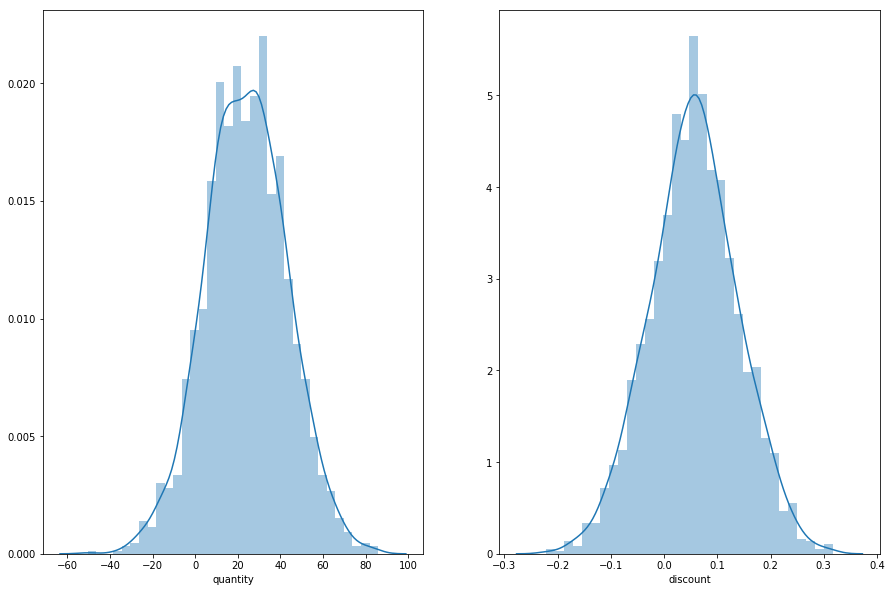

In [39]:
fig = plt.figure(figsize=(15,10))
plt.subplot(121)
sns.distplot(norm_h1['quantity'])
plt.subplot(122)
sns.distplot(norm_h1['discount'])

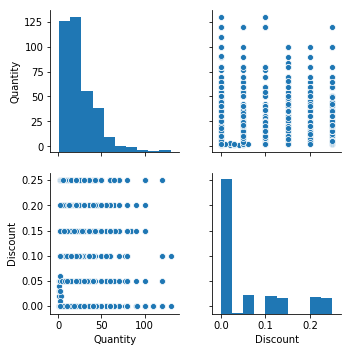

In [41]:
sns.pairplot(h1[['Quantity', 'Discount']])